# Solving classification problems with CatBoost

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb)

In this tutorial we will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/c/amazon-employee-access-challenge/data).

## Libraries installation

In [ ]:
#!pip install --user --upgrade catboost
#!pip install --user --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!pip install --upgrade numpy
#!jupyter nbextension enable --py widgetsnbextension

In [1]:
import catboost
print(catboost.__version__)
!python --version

1.2.5
Python 3.12.1


## Reading the data

In [2]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

In [3]:
(train_df, test_df) = catboost.datasets.amazon()

In [4]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


## Preparing your data

Label values extraction

In [6]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [7]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Looking on label balance in dataset

In [8]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


Ways to create Pool class

In [9]:
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.
train_df.to_csv(
    os.path.join(dataset_dir, 'train.tsv'),
    index=False, sep='\t', header=False
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.tsv'),
    index=False, sep='\t', header=False
)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.csv'),
    index=False, sep=',', header=True
)

In [11]:
from catboost.utils import create_cd
feature_names = dict()
for column, name in enumerate(train_df):
    if column == 0:
        continue
    feature_names[column] = name

create_cd(
    label=0,
    cat_features=list(range(1, train_df.columns.shape[0])),
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
)

In [13]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(
    data=os.path.join(dataset_dir, 'train.csv'),
    delimiter=',',
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True
)
pool3 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool4 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) +
      '\ndataset 3:' + str(pool3.shape) +
      '\ndataset 4: ' + str(pool4.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names())
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())
print('\ndataset 4:')
print(pool4.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)
dataset 4: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 4:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


## Split your data into train and validation

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

## Selecting the objective function

Possible options for binary classification:

`Logloss`

`CrossEntropy` for probabilities in target

In [15]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


## Stdout of the training

In [16]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.441257
0:	learn: 0.4220777	test: 0.4223741	best: 0.4223741 (0)	total: 35.8ms	remaining: 501ms
1:	learn: 0.3149660	test: 0.3151186	best: 0.3151186 (1)	total: 80.1ms	remaining: 520ms
2:	learn: 0.2621494	test: 0.2629766	best: 0.2629766 (2)	total: 116ms	remaining: 465ms
3:	learn: 0.2302316	test: 0.2302315	best: 0.2302315 (3)	total: 156ms	remaining: 429ms
4:	learn: 0.2060274	test: 0.2019603	best: 0.2019603 (4)	total: 203ms	remaining: 407ms
5:	learn: 0.1956107	test: 0.1894627	best: 0.1894627 (5)	total: 243ms	remaining: 365ms
6:	learn: 0.1870345	test: 0.1790904	best: 0.1790904 (6)	total: 293ms	remaining: 335ms
7:	learn: 0.1836943	test: 0.1748030	best: 0.1748030 (7)	total: 359ms	remaining: 314ms
8:	learn: 0.1807119	test: 0.1707896	best: 0.1707896 (8)	total: 436ms	remaining: 291ms
9:	learn: 0.1775777	test: 0.1662489	best: 0.1662489 (9)	total: 519ms	remaining: 259ms
10:	learn: 0.1762130	test: 0.1654446	best: 0.1654446 (10)	total: 576ms	remaining: 209ms
11:	learn: 0.1760650

## Metrics calculation and graph plotting

In [17]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Model comparison

In [18]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [19]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [20]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [21]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


## Cross-validation

In [22]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1695893693
bestIteration = 38

Training on fold [1/5]

bestTest = 0.1646328641
bestIteration = 48

Training on fold [2/5]

bestTest = 0.1515742763
bestIteration = 60

Training on fold [3/5]

bestTest = 0.1426916182
bestIteration = 78

Training on fold [4/5]

bestTest = 0.1563234371
bestIteration = 37



In [23]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302367,0.004317,0.302196,0.004517,0.513577,0.030360
1,1,0.227370,0.007679,0.228497,0.005126,0.642263,0.048004
2,2,0.190856,0.006917,0.196796,0.003999,0.791709,0.011361
3,3,0.178884,0.007455,0.186682,0.003242,0.813889,0.009362
4,4,0.172286,0.007957,0.181380,0.002135,0.826529,0.005319


In [24]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1581±0.0104 on step 52


In [25]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1614486451
bestIteration = 31

Training on fold [1/5]

bestTest = 0.1551886688
bestIteration = 56

Training on fold [2/5]

bestTest = 0.156915781
bestIteration = 57

Training on fold [3/5]

bestTest = 0.1521221373
bestIteration = 59

Training on fold [4/5]

bestTest = 0.1576264978
bestIteration = 29

Best validation Logloss score, stratified: 0.1574±0.0036 on step 57


## Overfitting detector

In [26]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [27]:
print(model_with_early_stop.tree_count_)

30


In [28]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
print(model_with_early_stop.tree_count_)

30


## Select decision boundary

In [30]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [31]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

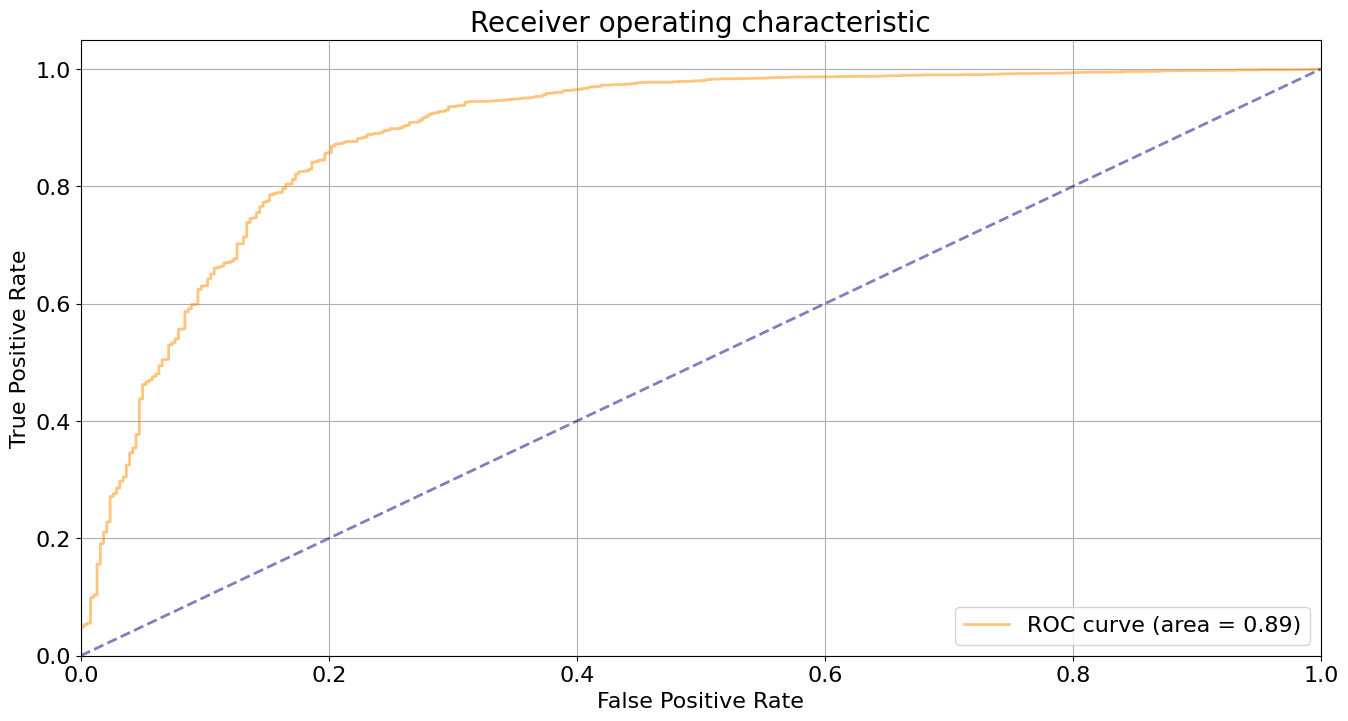

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [33]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

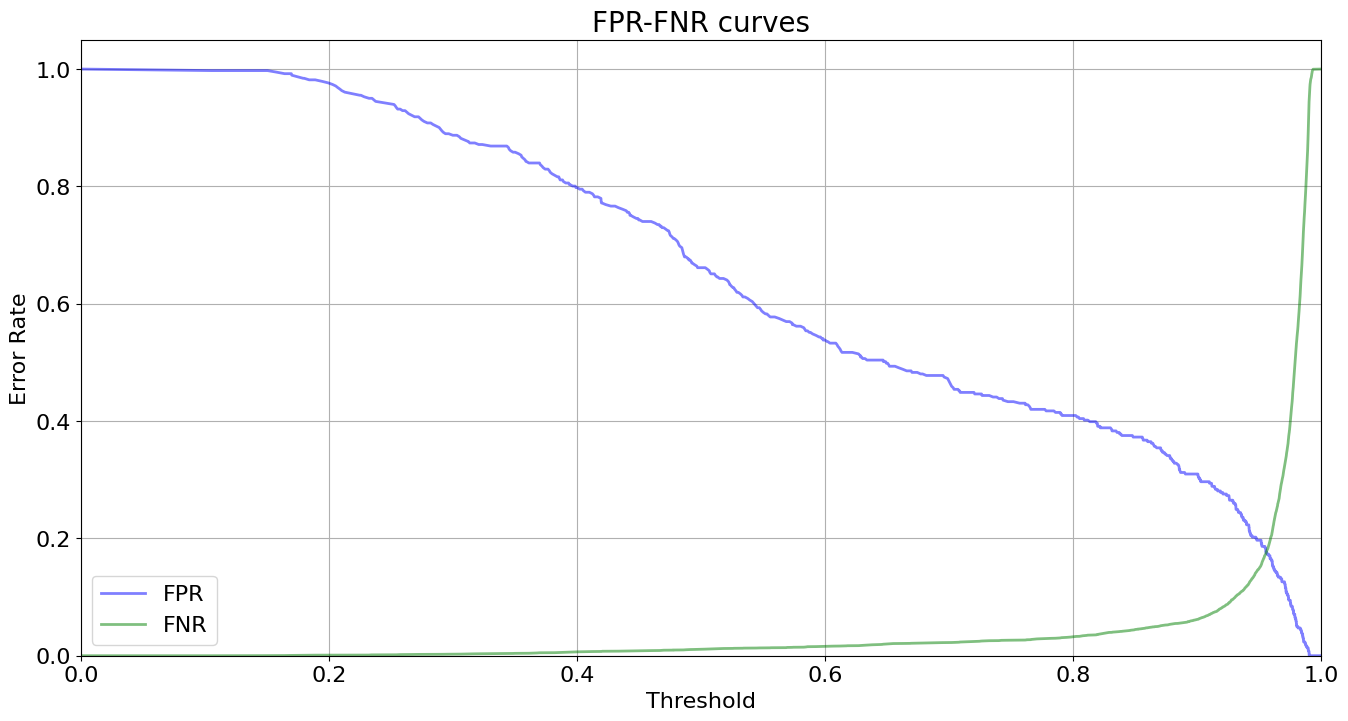

In [34]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [35]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.48689529945049076
0.9899713850692811


## Snapshotting

In [36]:
# !rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=True
)

Learning rate set to 0.193326
0:	learn: 0.5565905	test: 0.5566217	best: 0.5566217 (0)	total: 21.8ms	remaining: 2.16s
1:	learn: 0.4642626	test: 0.4639935	best: 0.4639935 (1)	total: 47ms	remaining: 2.3s
2:	learn: 0.3989148	test: 0.3981304	best: 0.3981304 (2)	total: 87.4ms	remaining: 2.83s
3:	learn: 0.3516186	test: 0.3510286	best: 0.3510286 (3)	total: 104ms	remaining: 2.49s
4:	learn: 0.3164302	test: 0.3161297	best: 0.3161297 (4)	total: 144ms	remaining: 2.73s
5:	learn: 0.2906047	test: 0.2905494	best: 0.2905494 (5)	total: 157ms	remaining: 2.46s
6:	learn: 0.2710475	test: 0.2708899	best: 0.2708899 (6)	total: 175ms	remaining: 2.32s
7:	learn: 0.2538458	test: 0.2539798	best: 0.2539798 (7)	total: 372ms	remaining: 4.28s
8:	learn: 0.2399269	test: 0.2401350	best: 0.2401350 (8)	total: 458ms	remaining: 4.63s
9:	learn: 0.2298664	test: 0.2304173	best: 0.2304173 (9)	total: 500ms	remaining: 4.5s
10:	learn: 0.2180381	test: 0.2161946	best: 0.2161946 (10)	total: 545ms	remaining: 4.41s
11:	learn: 0.2089276	te

## Model predictions

In [37]:
print(model.predict_proba(X=X_validation))

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


In [38]:
print(model.predict(data=X_validation))

[1 1 1 ... 1 1 1]


In [39]:
raw_pred = model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

[2.9282 3.9947 4.0077 ... 4.1115 4.06   3.7207]


In [40]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9492 0.9819 0.9821 ... 0.9839 0.983  0.9764]


In [41]:
X_prepared = X_validation.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

fast_predictions = model.predict_proba(
    X=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X_validation)
    )
)
print(fast_predictions)

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


## Staged prediction

In [ ]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0,
    ntree_end=5,
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.3726 0.6274]
 [0.3726 0.6274]
 [0.3726 0.6274]
 ...
 [0.3726 0.6274]
 [0.3726 0.6274]
 [0.3726 0.6274]]
Iteration 1, predictions:
[[0.2845 0.7155]
 [0.2845 0.7155]
 [0.2845 0.7155]
 ...
 [0.2845 0.7155]
 [0.2845 0.7155]
 [0.2845 0.7155]]
Iteration 2, predictions:
[[0.2174 0.7826]
 [0.2296 0.7704]
 [0.2396 0.7604]
 ...
 [0.2225 0.7775]
 [0.2174 0.7826]
 [0.2396 0.7604]]
Iteration 3, predictions:
[[0.1685 0.8315]
 [0.1818 0.8182]
 [0.2105 0.7895]
 ...
 [0.178  0.822 ]
 [0.1685 0.8315]
 [0.2105 0.7895]]
Iteration 4, predictions:
[[0.1388 0.8612]
 [0.1501 0.8499]
 [0.1695 0.8305]
 ...
 [0.147  0.853 ]
 [0.1343 0.8657]
 [0.175  0.825 ]]


/place/home/ilikepugs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: generator 'CatBoost._staged_predict' raised StopIteration
  


## Solving MultiClassification problem

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=43,
    loss_function='MultiClass'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

For multiclass problems with many classes sometimes it's better to solve classification problem using ranking.
To do that we will build a dataset with groups.
Every group will represent one object from our initial dataset.
But it will have one additional categorical feature - possible class value.
Target values will be equal to 1 if the class value is equal to the correct class, and 0 otherwise.
Thus each group will have exactly one 1 in labels, and some zeros.
You can put all possible class values in the group or you can try setting only hard negatives if there are too many labels.
We'll show this approach on an example of binary classification problem.

In [ ]:
from copy import deepcopy
def build_multiclass_ranking_dataset(X, y, cat_features, label_values=[0,1], start_group_id=0):
    ranking_matrix = []
    ranking_labels = []
    group_ids = []

    X_train_matrix = X.values
    y_train_vector = y.values

    for obj_idx in range(X.shape[0]):
        obj = list(X_train_matrix[obj_idx])

        for label in label_values:
            obj_of_given_class = deepcopy(obj)
            obj_of_given_class.append(label)
            ranking_matrix.append(obj_of_given_class)
            ranking_labels.append(float(y_train_vector[obj_idx] == label))
            group_ids.append(start_group_id + obj_idx)

    final_cat_features = deepcopy(cat_features)
    final_cat_features.append(X.shape[1]) # new feature that we are adding should be categorical.
    return Pool(ranking_matrix, ranking_labels, cat_features=final_cat_features, group_id = group_ids)

In [ ]:
from catboost import CatBoost
params = {'iterations':150, 'learning_rate':0.01, 'l2_leaf_reg':30, 'random_seed':0, 'loss_function':'QuerySoftMax'}

groupwise_train_pool = build_multiclass_ranking_dataset(X_train, y_train, cat_features, [0,1])
groupwise_eval_pool = build_multiclass_ranking_dataset(X_validation, y_validation, cat_features, [0,1], X_train.shape[0])

model = CatBoost(params)
model.fit(
    X=groupwise_train_pool,
    verbose=False,
    eval_set=groupwise_eval_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Doing predictions with ranking mode

In [ ]:
import math

obj = list(X_validation.values[0])
ratings = []
for label in [0,1]:
    obj_with_label = deepcopy(obj)
    obj_with_label.append(label)
    rating = model.predict([obj_with_label])[0]
    ratings.append(rating)
print('Raw values:', np.array(ratings))

def soft_max(values):
    return [math.exp(val) / sum([math.exp(val) for val in values]) for val in values]

print('Probabilities', np.array(soft_max(ratings)))

Raw values: [-0.472   0.4722]
Probabilities [0.2801 0.7199]


## Metric evaluation on a new dataset

In [42]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.6569860	total: 48.9ms	remaining: 9.73s
50:	learn: 0.1923495	total: 5.39s	remaining: 15.8s
100:	learn: 0.1655631	total: 10.2s	remaining: 10s
150:	learn: 0.1570882	total: 16.8s	remaining: 5.44s
199:	learn: 0.1538475	total: 22.3s	remaining: 0us


In [43]:
metrics = model.eval_metrics(
    data=pool1,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [44]:
print('AUC values:')
print(np.array(metrics['AUC']))

AUC values:
[0.4998 0.538  0.5504 0.5888 0.6536 0.6515 0.6476 0.648  0.7117 0.731
 0.7277 0.7278 0.7299 0.7298 0.7275 0.7273 0.7336 0.735  0.7445 0.7606
 0.7627 0.7627 0.7731 0.7769 0.7866 0.7985 0.7986 0.8008 0.8004 0.8004
 0.8191 0.8357 0.8518 0.8666 0.8851 0.8855 0.8886 0.8931 0.8936 0.8991
 0.9033 0.9115 0.9126 0.9136 0.9148 0.9163 0.9177 0.9184 0.9206 0.9211
 0.9259 0.9289 0.9291 0.9324 0.9329 0.9334 0.9338 0.9351 0.9361 0.937
 0.9378 0.938  0.9383 0.9393 0.9405 0.9416 0.943  0.9441 0.945  0.9448
 0.9457 0.9458 0.9463 0.9464 0.9467 0.9469 0.9484 0.9494 0.9503 0.9515
 0.9523 0.9528 0.9539 0.9546 0.955  0.9556 0.9559 0.9563 0.9565 0.9567
 0.9572 0.9576 0.9583 0.9591 0.9602 0.9608 0.9613 0.9619 0.9622 0.9625
 0.9629 0.9633 0.9637 0.9639 0.9647 0.9655 0.9661 0.9667 0.9673 0.9675
 0.9682 0.9687 0.9691 0.9694 0.9699 0.9703 0.9706 0.9707 0.9711 0.9715
 0.9716 0.972  0.9723 0.9726 0.9728 0.973  0.9731 0.9731 0.9733 0.9734
 0.9738 0.9738 0.9739 0.974  0.9741 0.9742 0.9744 0.9744 0.9745 0.9


## Feature importances

In [45]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,23.053159
1,ROLE_DEPTNAME,17.444028
2,MGR_ID,15.435686
3,ROLE_ROLLUP_2,13.141622
4,ROLE_CODE,10.487834
5,ROLE_FAMILY_DESC,7.121037
6,ROLE_TITLE,6.394562
7,ROLE_FAMILY,4.287269
8,ROLE_ROLLUP_1,2.634803


## Shap values

In [46]:
shap_values = model.get_feature_importance(pool1, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(32769, 9)


In [48]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

In [49]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X.iloc[91,:])

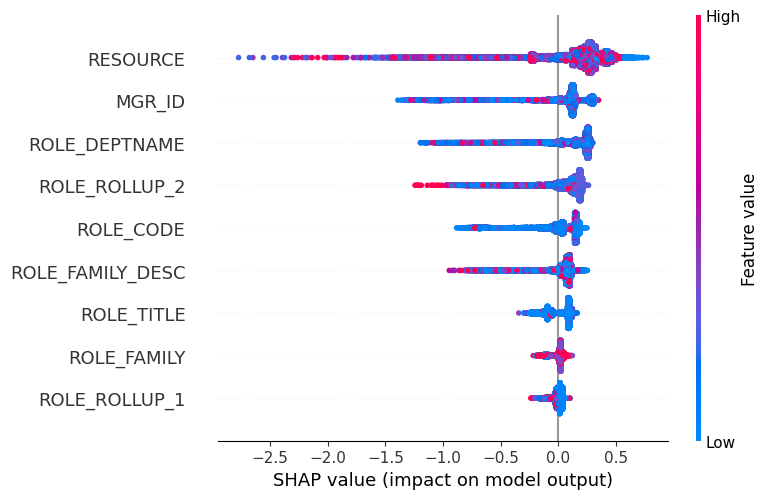

In [50]:
shap.summary_plot(shap_values, X)

In [51]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

## Feature evaluation

In [ ]:
from catboost.eval.catboost_evaluation import *
learn_params = {'iterations': 20, # 2000
                'learning_rate': 0.5, # we set big learning_rate,
                                      # because we have small
                                      # #iterations
                'random_seed': 0,
                'verbose': False,
                'loss_function' : 'Logloss',
                'boosting_type': 'Plain'}
evaluator = CatboostEvaluation('amazon/train.tsv',
                               fold_size=10000, # <= 50% of dataset
                               fold_count=20,
                               column_description='amazon/train.cd',
                               partition_random_seed=0,
                               #working_dir=...
)
result = evaluator.eval_features(learn_config=learn_params,
                                 eval_metrics=['Logloss', 'Accuracy'],
                                 features_to_eval=[6, 7, 8])

In [ ]:
from catboost.eval.evaluation_result import *
logloss_result = result.get_metric_results('Logloss')
logloss_result.get_baseline_comparison(
    ScoreConfig(ScoreType.Rel, overfit_iterations_info=False)
)

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision
Features: 6,0.000449,1.039991,0.617431,1.467979,GOOD
Features: 7,0.681322,-0.028710,-0.351553,0.287576,UNKNOWN
Features: 8,0.262722,-0.206858,-0.630120,0.194727,UNKNOWN


## Saving the model

In [ ]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [ ]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'logging_level': 'Silent', 'verbose': 0}
0


## Hyperparameter tunning

### Training speed

In [52]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Accuracy

In [53]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

## Training the model after parameter tunning

In [ ]:
best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
)
best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

Learning rate set to 0.050252
0:	learn: 0.6336427	total: 50ms	remaining: 44.1s
100:	learn: 0.1568193	total: 5.93s	remaining: 45.9s
200:	learn: 0.1507586	total: 13s	remaining: 44.1s
300:	learn: 0.1479960	total: 19.9s	remaining: 38.4s
400:	learn: 0.1458206	total: 27.8s	remaining: 33.4s
500:	learn: 0.1439574	total: 37s	remaining: 28.2s
600:	learn: 0.1427374	total: 46s	remaining: 21.6s
700:	learn: 0.1414658	total: 55.1s	remaining: 14.3s
800:	learn: 0.1404199	total: 1m 2s	remaining: 6.41s
882:	learn: 0.1397396	total: 1m 9s	remaining: 0us


## Calculate predictions for the contest

In [ ]:
X_test = test_df.drop('id', axis=1)
test_pool = Pool(data=X_test, cat_features=cat_features)
contest_predictions = best_model.predict_proba(test_pool)
print('Predictoins:')
print(contest_predictions)

Predictoins:
[[0.2754 0.7246]
 [0.0157 0.9843]
 [0.0101 0.9899]
 ...
 [0.0069 0.9931]
 [0.0561 0.9439]
 [0.0147 0.9853]]


## Prepare the submission

In [ ]:
f = open('submit.csv', 'w')
f.write('Id,Action\n')
for idx in range(len(contest_predictions)):
    line = str(test_df['id'][idx]) + ',' + str(contest_predictions[idx][1]) + '\n'
    f.write(line)
f.close()

Submit your solution [here](https://www.kaggle.com/c/amazon-employee-access-challenge/submit).
Good luck!!!